In [2]:
# -----------------------------------------------------------------------------
# Initialization: Configure parallel processing
# -----------------------------------------------------------------------------

import sys
sys.path.append('..')

from baseline.utilities import *
from pandarallel import pandarallel
import pandas as pd
import json
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
# -----------------------------------------------------------------------------
# Load Data: Read CSV files and inspect data
# -----------------------------------------------------------------------------

SENTINEL_TIFF_PATH = '../baseline/S2_sample.tiff'
LANDSAT_TIFF_PATH = '../baseline/Landsat_LST.tiff'
MODE = 'submission'  # 'train' o 'submission'

if MODE == 'train':
    ground_df = pd.read_csv("../baseline/Training_data_uhi_index.csv")
elif MODE == 'submission':
    ground_df = pd.read_csv("../baseline/Submission_template.csv")
else:
    raise ValueError("MODE should be either 'train' or 'submission'")

display(ground_df[['Longitude', 'Latitude']].describe())

radius_list = json.loads(open("../pipeline/data/radius_list.json", "r").read())['radius_list']
print(f"{radius_list=}")

bbox_dataset = pd.read_parquet(f'../pipeline/data/processed/{MODE}/bbox_dataset.parquet')


,Longitude,Latitude
count,1040.000000,1040.000000
mean,-73.934816,40.807991
std,0.028661,0.023200
min,-73.993163,40.758877
25%,-73.957030,40.790802
50%,-73.934618,40.809553
75%,-73.910655,40.823054
max,-73.879537,40.859243


radius_list=[50, 100, 150, 200, 250, 275, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]


lwir11_arr.shape=(3, 3)


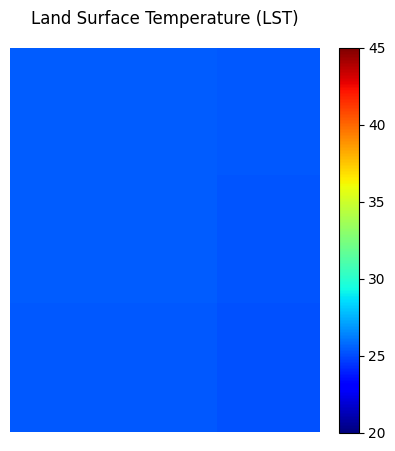

25.321153940000006 0.08061182761736614
25.321153940000006 0.08061182761736614


In [4]:
# -----------------------------------------------------------------------------
# Feature Engineering: Extract features from Landsat TIFF
# -----------------------------------------------------------------------------

landsat_features_df = bbox_dataset.copy()

sample = landsat_features_df['buffer_50m_bbox_4326'].iloc[0]
selection = get_bbox_selection(LANDSAT_TIFF_PATH, sample)
lwir11_arr = selection.sel(band=1).to_numpy()
print(f"{lwir11_arr.shape=}")

fig, ax = plt.subplots(figsize=(5, 5))
selection.sel(band=1).plot.imshow(vmin=20.0, vmax=45.0, cmap="jet")
plt.title("Land Surface Temperature (LST)")
plt.axis('off')
plt.show()

print(np.nanmean(lwir11_arr), np.nanstd(lwir11_arr))
print(np.nanmean(selection.sel(band=1)), np.nanstd(selection.sel(band=1)))

In [5]:
# -----------------------------------------------------------------------------
# Compute Temperature Statistics per Radius
# -----------------------------------------------------------------------------

landsat_feature_list = []
for r in tqdm(radius_list, total=len(radius_list), desc='Landsat LWIR11'):
    
    landsat_features_df[f'ldnst_buffer_{r}m_selection'] = landsat_features_df[f'buffer_{r}m_bbox_4326'].parallel_apply(
        lambda bbox: get_bbox_selection(LANDSAT_TIFF_PATH, bbox)
    )

    # media de la temperatura
    landsat_features_df[f'lndst_mean_lwir11_{r}m'] = landsat_features_df[f'ldnst_buffer_{r}m_selection'].parallel_apply(
        lambda patch: np.nanmean(patch.sel(band=1))
    )

    # desviación estándar de la temperatura
    landsat_features_df[f'lndst_std_lwir11_{r}m'] = landsat_features_df[f'ldnst_buffer_{r}m_selection'].parallel_apply(
        lambda patch: np.nanstd(patch.sel(band=1))
    )

    landsat_feature_list.extend([f'lndst_mean_lwir11_{r}m', f'lndst_std_lwir11_{r}m'])

Landsat LWIR11: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


In [6]:
# -----------------------------------------------------------------------------
# Extract Point Value from Landsat Data
# -----------------------------------------------------------------------------

landsat_data = rxr.open_rasterio(LANDSAT_TIFF_PATH)

landsat_features_df['lndst_lwir_point'] = ground_df[['Latitude', 'Longitude']].progress_apply(
    lambda x: landsat_data.sel(x=x['Longitude'], y=x['Latitude'], method='nearest').values[0],
    axis=1
)

landsat_feature_list.append('lndst_lwir_point')

display(landsat_features_df[landsat_feature_list])

landsat_features_df[landsat_feature_list].to_parquet(f'../pipeline/data/processed/{MODE}/landsat.parquet')

100%|██████████| 1040/1040 [00:00<00:00, 3091.32it/s]


,lndst_mean_lwir11_50m,lndst_std_lwir11_50m,lndst_mean_lwir11_100m,lndst_std_lwir11_100m,lndst_mean_lwir11_150m,lndst_std_lwir11_150m,lndst_mean_lwir11_200m,lndst_std_lwir11_200m,lndst_mean_lwir11_250m,lndst_std_lwir11_250m,lndst_mean_lwir11_275m,lndst_std_lwir11_275m,lndst_mean_lwir11_300m,lndst_std_lwir11_300m,lndst_mean_lwir11_350m,lndst_std_lwir11_350m,lndst_mean_lwir11_400m,lndst_std_lwir11_400m,lndst_mean_lwir11_450m,lndst_std_lwir11_450m,lndst_mean_lwir11_500m,lndst_std_lwir11_500m,lndst_mean_lwir11_600m,lndst_std_lwir11_600m,lndst_mean_lwir11_700m,lndst_std_lwir11_700m,lndst_mean_lwir11_800m,lndst_std_lwir11_800m,lndst_mean_lwir11_900m,lndst_std_lwir11_900m,lndst_mean_lwir11_1000m,lndst_std_lwir11_1000m,lndst_lwir_point
0,25.321154,0.080612,25.171770,0.423057,24.993594,0.605852,24.821720,0.707046,24.679499,0.775270,24.632376,0.826952,24.621371,0.824293,24.608645,0.850345,24.619972,0.906896,24.644109,0.930549,24.657105,0.971091,24.544675,1.303292,24.334324,1.789935,24.106064,2.186051,23.756860,2.614108,23.396944,3.053138,25.398629
1,25.412301,0.066101,25.170012,0.400773,24.965865,0.543728,24.812702,0.607915,24.709349,0.720574,24.673970,0.742252,24.637721,0.802390,24.594882,0.820673,24.593495,0.858971,24.644510,0.935366,24.654744,0.968115,24.600009,1.200123,24.409337,1.628519,24.154830,2.065845,23.790726,2.604276,23.407644,3.046946,25.398629
2,23.990785,0.205444,23.820969,0.505146,23.636884,0.892115,23.780256,1.295317,23.579268,1.783986,23.468901,1.921526,23.273111,2.276003,23.180369,2.528650,22.961695,2.964889,22.765907,3.224179,22.762648,3.343461,22.495884,3.729628,22.461897,3.877482,22.415248,3.997023,22.351116,4.050751,22.467184,3.884020,23.853684
3,25.172660,0.445721,24.970693,0.518893,24.826062,0.534198,24.774661,0.512665,24.694362,0.619669,24.646928,0.688023,24.609784,0.715164,24.576276,0.791759,24.577135,0.833936,24.586681,0.853507,24.611929,0.906282,24.603898,1.145524,24.498626,1.432525,24.211853,1.919610,23.814221,2.569135,23.353313,3.172126,25.518260
4,23.173213,0.604787,23.382453,0.790290,23.613226,0.881358,23.868308,0.896024,24.081377,0.880522,24.125105,0.857301,24.220107,0.855637,24.203715,1.019088,24.152702,1.265565,24.044702,1.763403,23.857983,2.283329,23.694062,2.710796,23.532252,2.973646,23.290989,3.153892,23.127772,3.279784,23.055844,3.387339,22.742828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,31.008739,0.621845,30.832939,0.748344,30.414085,0.743419,29.910593,0.811209,29.704776,0.850896,29.619884,0.861582,29.511715,0.903681,29.381443,0.996080,29.338636,1.128419,29.312049,1.204029,29.333695,1.209948,29.458504,1.163506,29.536994,1.188537,29.575522,1.277195,29.536340,1.334000,29.441664,1.375318,31.144321
1036,27.301707,0.109303,27.388210,0.242656,27.607647,0.713328,27.384630,0.815487,27.175984,1.064310,27.168133,1.093628,26.914418,1.647446,26.159617,2.865001,25.740241,3.328653,25.758963,3.365079,25.725035,3.320666,26.222763,3.175008,26.626500,3.054090,26.924729,2.948384,27.061532,2.821974,27.167374,2.712181,27.227270
1037,30.035173,0.356337,29.430721,0.844421,29.151102,1.053971,28.734248,1.211976,28.363491,1.266485,28.208588,1.374136,28.142228,1.340456,27.833077,1.553729,27.522985,1.735630,27.325050,1.876757,27.151970,2.038143,26.806831,2.624409,26.424890,3.381724,25.972529,4.133154,25.497681,4.739286,25.031234,5.167328,29.958268
1038,29.742932,0.162407,29.731995,0.399375,29.721008,0.598956,29.770210,0.721297,29.791459,0.735604,29.780531,0.733053,29.808957,0.748516,29.860142,0.822435,29.870238,0.867210,29.895569,0.920978,29.890289,0.998451,29.719257,1.166489,29.470812,1.293395,29.314477,1.307364,29.278151,1.283164,29.289384,1.296158,29.712170
